# Generative Adversarial Network (GAN): Monet Image Generator

Link: https://www.kaggle.com/competitions/gan-getting-started/overview

The task of this assignment is to generate 7,000 Monet-style images from the provided photos utilizing a Generative Adversarial Network (GAN). This assignment utilizes a CycleGAN process that includes a generator and discriminator, that are both described further below. 

### Import Libraries

In [1]:
# Math functions and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing and data procssing
import os
import glob
from tqdm import tqdm
from PIL import Image
import zipfile

# Tensorflow for model building
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Activation
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

### Loading the Data and EDA:


In [2]:
# Create a directory for the Monet_jpg and Photo_jpg files
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

In [3]:
# Load the data from the directories

def image_loader(dir, count=5, size=(256, 256)):
    img_file = tf.io.gfile.glob(os.path.join(dir, '*jpg'))[:count]
    images = []

    for file in img_file:
        img = tf.keras.preprocessing.image.load_img(file, target_size=size)
        array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(array.astype('uint8'))
    return images

monet_images = image_loader(monet_dir)
photo_images = image_loader(photo_dir)

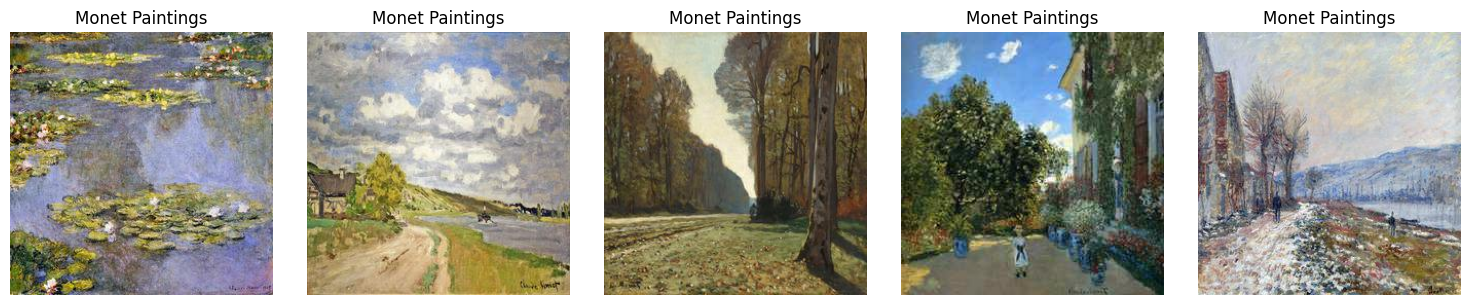

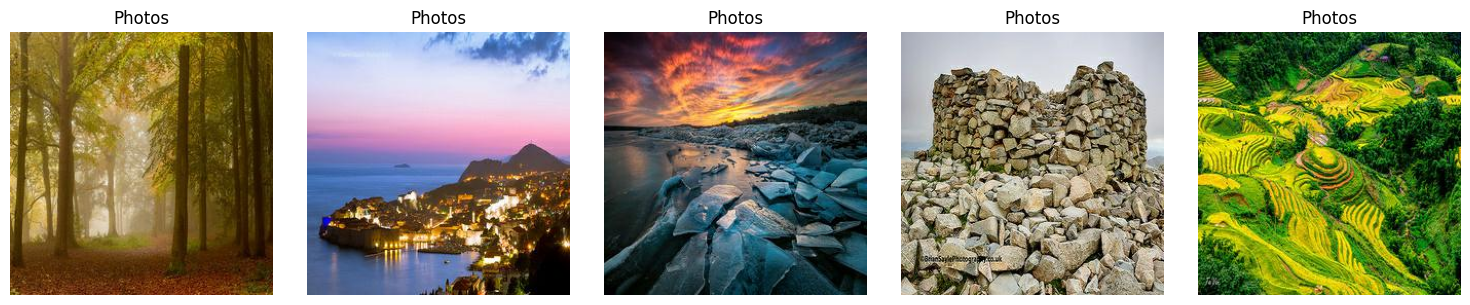

In [4]:
# Create a function to develop the first five images

def plot_images(images, title, rows=1, cols=5):
    plt.figure(figsize=(15, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()



# Display Monet paintings and Regular photos

plot_images(monet_images, title="Monet Paintings")
plot_images(photo_images, title="Photos")

### Model Development:
This model is a CycleGAN, a type of Generative Adversarial Network (GAN) designed to translate images between two domains without requiring paired examples. In this case the two domains are real-word images and Monet paintings. The model consists of two generators, G and F that translate photos to Monet-style images and translate Monet paintings into photo-style images, respectively. The model also consists of two discriminators that distinguish real Monet paintings from generated Monet-style images and real photos from generated photo images. 


The generator is based on a U-Net architecture that consists of the following
- Downsampling Layers:
Utilized for reducing dimension size and extracting complex features. 
  - First: Convolutional layer utilziing ReLU activation; 64 filters, 4x4 kernel, with a stride of 2. 
  - Second: Convolutional layer utilziing ReLU activation; 128 filters, 4x4 kernel, with a stride of 2.  
- Bottleneck Layer:
  - A more compressed version of the image representation. 
  - Single layer; 256 filters, 4x4 kernel, with a stride of 2.
- Upsampling Layer:
  - Utilized for reconstructing image back to it’s original shape. 
  - First: Transposed convolutional layer utilziing ReLU activation; 128 filters, 4x4 kernel, with a stride of 2. 
  - Second: Transposed convolutional layer utilziing ReLU activation; 64 filters, 4x4 kernel, with a stride of 2.  
- Output Layer: 
  - Outputs the image pixel values that are on a scale of [-1,1].
  - Three filters that correspond to the RGB channels with 4x4 kernels and an activation of tanh. 

The discriminator architecture consists of the following: 
- Downsampling Layers:
  - Utilized for reducing dimension size and extracting complex features. 
  - First: Convolutional layer utilziing ReLU activation; 64 filters, 4x4 kernel, with a stride of 2. 
  - Second: Convolutional layer utilziing ReLU activation; 128 filters, 4x4 kernel, with a stride of 2.  
  - Third: Convolutional layer utilziing ReLU activation; 256 filters, 4x4 kernel, with a stride of 2.  
- Classify Layer:
  - Predicts whether each input image is real or fake. 
  - Single layer; 1 filters, 4x4 kernel, with a stride of 1. Sigmoid activation. 

The training process consists of a forward pass (translates the photos to Monet paintings and translates Monet paintings back to photos), discriminator training (learns to classify real Monet paintings vs. fake Monet paintings and learns to classify real photos vs. fake generated photos), generator training (that was optimized using cycle-consistency losses and adversarial losses) and iterative updates (generators and discriminators updated alternatively to ensure balance). 


In [5]:
# Build the Generator:

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Downsample
    x = layers.Conv2D(64, (4, 4), strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, (4, 4), strides=2, padding="same", activation="relu")(x)
    # Bottleneck
    x = layers.Conv2D(256, (4, 4), strides=2, padding="same", activation="relu")(x)
    # Upsample
    x = layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding="same", activation="relu")(x)
    # Output layer
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding="same", activation="tanh")(x)
    return Model(inputs, outputs, name="Generator")



# Build the Discriminator

def build_discriminator():

    inputs = layers.Input(shape=(256, 256, 3))

    # Downsample
    x = layers.Conv2D(64, (4, 4), strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, (4, 4), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (4, 4), strides=2, padding="same", activation="relu")(x)

    # Classify
    outputs = layers.Conv2D(1, (4, 4), padding="same", activation="sigmoid")(x)
    return Model(inputs, outputs, name="Discriminator")

# Instantiate the models
generator = build_generator()
discriminator = build_discriminator()

# Print model summaries
generator.summary()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

In [7]:
@tf.function

def train_step(real_photo, real_monet):
    # Define labels for real and fake images
    real_label = tf.ones((real_photo.shape[0], 32, 32, 1))  # Match discriminator output size
    fake_label = tf.zeros((real_photo.shape[0], 32, 32, 1))


    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images and reconstructed images
        fake_monet = generator_g(real_photo, training=True)
        cycled_photo = generator_f(fake_monet, training=True)
        fake_photo = generator_f(real_monet, training=True)
        cycled_monet = generator_g(fake_photo, training=True)

        # Identity mapping
        same_monet = generator_g(real_monet, training=True)
        same_photo = generator_f(real_photo, training=True)

        # Discriminator predictions
        disc_real_monet = discriminator_x(real_monet, training=True)
        disc_fake_monet = discriminator_x(fake_monet, training=True)
        disc_real_photo = discriminator_y(real_photo, training=True)
        disc_fake_photo = discriminator_y(fake_photo, training=True)

        # Losses
        gen_g_adv_loss = tf.keras.losses.MeanSquaredError()(real_label, disc_fake_monet)
        gen_f_adv_loss = tf.keras.losses.MeanSquaredError()(real_label, disc_fake_photo)

        cycle_loss_g = tf.keras.losses.MeanAbsoluteError()(real_photo, cycled_photo) * 20
        cycle_loss_f = tf.keras.losses.MeanAbsoluteError()(real_monet, cycled_monet) * 20

        id_loss_g = tf.keras.losses.MeanAbsoluteError()(real_monet, same_monet) * 5
        id_loss_f = tf.keras.losses.MeanAbsoluteError()(real_photo, same_photo) * 5

        # Total generator loss
        total_gen_g_loss = gen_g_adv_loss + cycle_loss_g + id_loss_g
        total_gen_f_loss = gen_f_adv_loss + cycle_loss_f + id_loss_f

        # Discriminator loss
        disc_x_loss = (tf.keras.losses.MeanSquaredError()(real_label, disc_real_monet) +
                       tf.keras.losses.MeanSquaredError()(fake_label, disc_fake_monet)) * 0.5
        disc_y_loss = (tf.keras.losses.MeanSquaredError()(real_label, disc_real_photo) +
                       tf.keras.losses.MeanSquaredError()(fake_label, disc_fake_photo)) * 0.5

    # Calculate discriminator accuracy (after predictions)
    disc_x_accuracy = tf.reduce_mean(
        tf.cast(tf.equal(tf.round(disc_real_monet), real_label), tf.float32)
    )
    disc_y_accuracy = tf.reduce_mean(
        tf.cast(tf.equal(tf.round(disc_real_photo), real_label), tf.float32)
    )

    # Apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
        "disc_x_accuracy": disc_x_accuracy,
        "disc_y_accuracy": disc_y_accuracy,
    }


In [8]:
def train(dataset, epochs):
    # Initialize lists to store metrics
    epoch_gen_g_loss = []
    epoch_gen_f_loss = []
    epoch_disc_x_loss = []
    epoch_disc_y_loss = []
    epoch_disc_x_accuracy = []
    epoch_disc_y_accuracy = []

    for epoch in range(epochs):
        gen_g_loss_sum = 0
        gen_f_loss_sum = 0
        disc_x_loss_sum = 0
        disc_y_loss_sum = 0
        disc_x_acc_sum = 0
        disc_y_acc_sum = 0
        num_batches = 0

        for real_photo, real_monet in dataset:
            losses = train_step(real_photo, real_monet)

            # Accumulate losses and accuracies
            gen_g_loss_sum += losses["gen_g_loss"].numpy()
            gen_f_loss_sum += losses["gen_f_loss"].numpy()
            disc_x_loss_sum += losses["disc_x_loss"].numpy()
            disc_y_loss_sum += losses["disc_y_loss"].numpy()
            disc_x_acc_sum += losses["disc_x_accuracy"].numpy()
            disc_y_acc_sum += losses["disc_y_accuracy"].numpy()
            num_batches += 1

        # Compute average metrics for the epoch
        epoch_gen_g_loss.append(gen_g_loss_sum / num_batches)
        epoch_gen_f_loss.append(gen_f_loss_sum / num_batches)
        epoch_disc_x_loss.append(disc_x_loss_sum / num_batches)
        epoch_disc_y_loss.append(disc_y_loss_sum / num_batches)
        epoch_disc_x_accuracy.append(disc_x_acc_sum / num_batches)
        epoch_disc_y_accuracy.append(disc_y_acc_sum / num_batches)
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Generator G Loss: {epoch_gen_g_loss[-1]:.4f}")
        print(f"  Generator F Loss: {epoch_gen_f_loss[-1]:.4f}")
        print(f"  Discriminator X Loss: {epoch_disc_x_loss[-1]:.4f}")
        print(f"  Discriminator Y Loss: {epoch_disc_y_loss[-1]:.4f}")
        print(f"  Discriminator X Accuracy: {epoch_disc_x_accuracy[-1]:.4f}")
        print(f"  Discriminator Y Accuracy: {epoch_disc_y_accuracy[-1]:.4f}")

    return epoch_gen_g_loss, epoch_gen_f_loss, epoch_disc_x_loss, epoch_disc_y_loss, epoch_disc_x_accuracy, epoch_disc_y_accuracy

def preprocess_image(image):
    image = tf.image.resize(image, (256, 256))
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(photo_path, monet_path, batch_size=1):
    photo_ds = tf.data.Dataset.list_files(photo_path + '/*.jpg')
    photo_ds = photo_ds.map(lambda x: preprocess_image(tf.io.decode_jpeg(tf.io.read_file(x))), num_parallel_calls=tf.data.AUTOTUNE)
    monet_ds = tf.data.Dataset.list_files(monet_path + '/*.jpg')
    monet_ds = monet_ds.map(lambda x: preprocess_image(tf.io.decode_jpeg(tf.io.read_file(x))), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((photo_ds, monet_ds))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [9]:
# Load dataset
dataset = load_dataset(photo_dir, monet_dir, batch_size=1)

# Define the generators
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo

# Define the discriminators
discriminator_x = build_discriminator()  # Monet discriminator
discriminator_y = build_discriminator()  # Photo discriminator

# Train the CycleGAN
gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, disc_x_acc, disc_y_acc = train(dataset, epochs=20)

Epoch 1/20
  Generator G Loss: 6.6793
  Generator F Loss: 6.0720
  Discriminator X Loss: 0.1826
  Discriminator Y Loss: 0.1933
  Discriminator X Accuracy: 0.7526
  Discriminator Y Accuracy: 0.7885
Epoch 2/20
  Generator G Loss: 4.5401
  Generator F Loss: 4.3649
  Discriminator X Loss: 0.2091
  Discriminator Y Loss: 0.1984
  Discriminator X Accuracy: 0.6969
  Discriminator Y Accuracy: 0.6825
Epoch 3/20
  Generator G Loss: 4.5846
  Generator F Loss: 4.3836
  Discriminator X Loss: 0.1832
  Discriminator Y Loss: 0.1869
  Discriminator X Accuracy: 0.6869
  Discriminator Y Accuracy: 0.6610
Epoch 4/20
  Generator G Loss: 4.3754
  Generator F Loss: 4.2819
  Discriminator X Loss: 0.1693
  Discriminator Y Loss: 0.1785
  Discriminator X Accuracy: 0.7121
  Discriminator Y Accuracy: 0.6483
Epoch 5/20
  Generator G Loss: 4.3019
  Generator F Loss: 4.2276
  Discriminator X Loss: 0.1662
  Discriminator Y Loss: 0.1659
  Discriminator X Accuracy: 0.7123
  Discriminator Y Accuracy: 0.6803
Epoch 6/20
  Ge

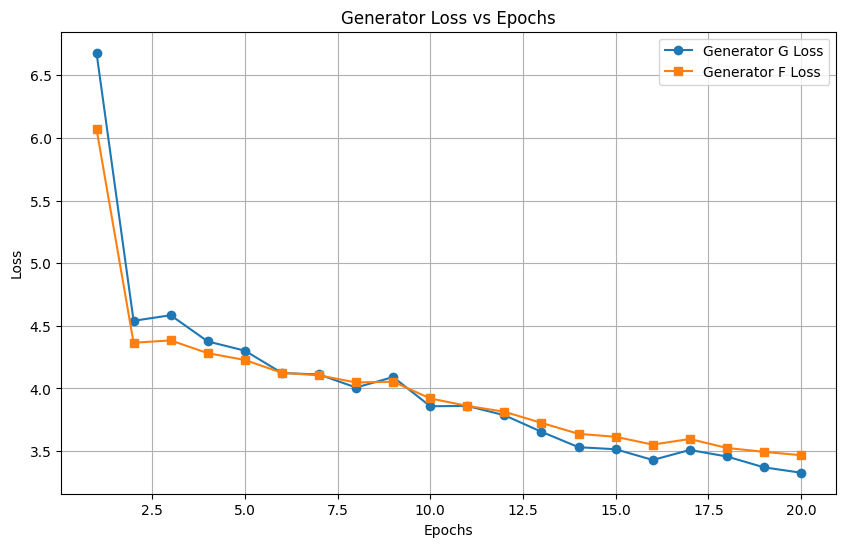

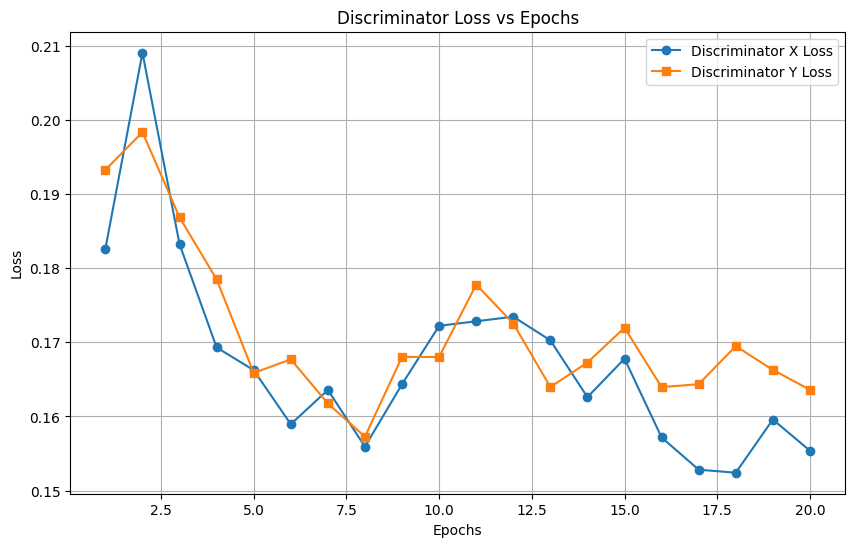

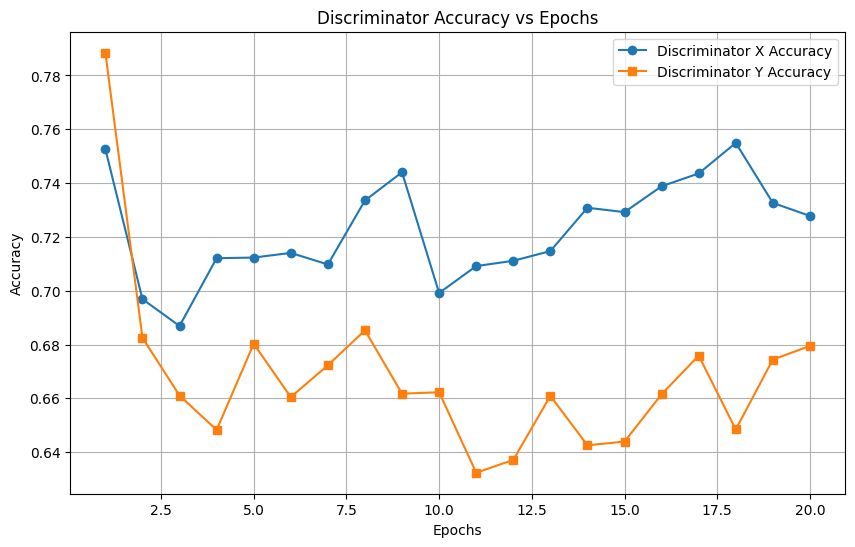

In [10]:
epochs = list(range(1, 21))

# Plot generator loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, gen_g_loss, label="Generator G Loss", marker="o")
plt.plot(epochs, gen_f_loss, label="Generator F Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot discriminator loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, disc_x_loss, label="Discriminator X Loss", marker="o")
plt.plot(epochs, disc_y_loss, label="Discriminator Y Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, disc_x_acc, label="Discriminator X Accuracy", marker="o")
plt.plot(epochs, disc_y_acc, label="Discriminator Y Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy vs Epochs")
plt.legend()
plt.grid()
plt.show()

Generated image pixel range: -0.9987273 0.9868002


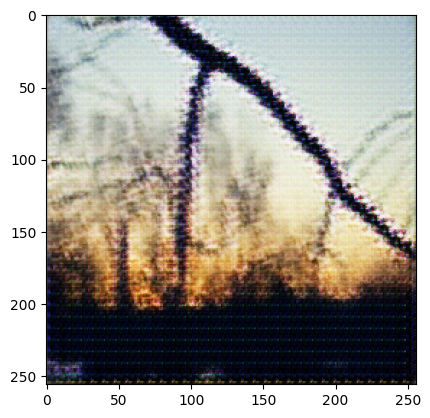

In [11]:
for photo, _ in dataset.take(1):
    generated_monet = generator_g(photo, training=False)
    print("Generated image pixel range:", generated_monet.numpy().min(), generated_monet.numpy().max())
plt.imshow((generated_monet[0].numpy() + 1) / 2)  # Convert to [0, 1]


In [12]:
import os
import zipfile
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

# Paths for saving images
output_zip_path = "images.zip"  # Final zip file
temp_dir = "../tmp/generated_images"  # Temporary directory for storing images
os.makedirs(temp_dir, exist_ok=True)

# Function to generate and zip images
def generate_and_zip_images(generator, photo_dataset, num_images=7000, temp_dir=temp_dir, zip_file_path=output_zip_path):
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        img_counter = 0

        # Iterate over the photo dataset to generate images
        for photo in tqdm(photo_dataset.take(num_images), desc="Generating and Zipping Images"):
            # Ensure the input shape is correct for the generator
            photo = tf.squeeze(photo, axis=0)  # Remove extra batch dimension if necessary
            photo = tf.expand_dims(photo, axis=0)  # Add single batch dimension
            
            # Generate Monet-style image
            generated_image = generator(photo, training=False)

            # Rescale pixel values from [-1, 1] to [0, 255]
            generated_image = ((generated_image[0].numpy() + 1) * 127.5).astype('uint8')
            original_photo = ((photo[0].numpy() + 1) * 127.5).astype('uint8')  # Rescale original photo

            # Name the files with a consistent and sortable format
            img_counter_str = f"{img_counter + 1:04d}"  # Zero-padded counter (e.g., 0001, 0002)
            generated_img_filename = f"generated_image_{img_counter_str}.jpg"
            original_img_filename = f"original_image_{img_counter_str}.jpg"

            generated_img_path = os.path.join(temp_dir, generated_img_filename)
            original_img_path = os.path.join(temp_dir, original_img_filename)

            # Save the images temporarily
            Image.fromarray(generated_image).save(generated_img_path, "JPEG")
            Image.fromarray(original_photo).save(original_img_path, "JPEG")

            # Add both images to the zip file
            zipf.write(generated_img_path, arcname=os.path.join("images", generated_img_filename))
            zipf.write(original_img_path, arcname=os.path.join("images", original_img_filename))

            img_counter += 1  # Increment the image counter

            # Stop if we reach the desired number of images
            if img_counter >= num_images:
                break

        print(f"Saved and zipped {img_counter} pairs of images (original + generated).")

# Ensure the dataset repeats indefinitely
photo_dataset = dataset.map(lambda photo, monet: photo).repeat()  # Repeat indefinitely

# Generate and zip 7,000 images
generate_and_zip_images(generator_g, photo_dataset, num_images=7000)


Generating and Zipping Images: 100%|█████████▉| 6999/7000 [01:26<00:00, 80.87it/s]


Saved and zipped 7000 pairs of images (original + generated).


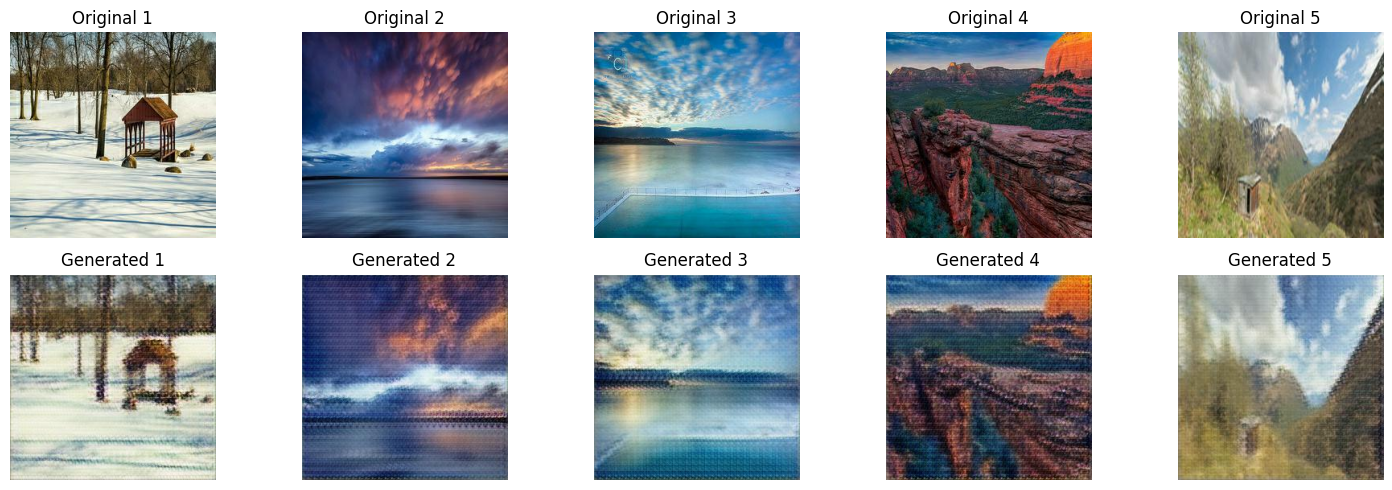

In [13]:
# Display pairs of original and generated images
def display_image_pairs(temp_dir, num_pairs=5):
    original_images = sorted([img for img in os.listdir(temp_dir) if img.startswith("original_image")])
    generated_images = sorted([img for img in os.listdir(temp_dir) if img.startswith("generated_image")])

    plt.figure(figsize=(15, 5))
    for i in range(num_pairs):
        original_img_path = os.path.join(temp_dir, original_images[i])
        generated_img_path = os.path.join(temp_dir, generated_images[i])

        # Display original image
        original_img = Image.open(original_img_path)
        plt.subplot(2, num_pairs, i + 1)
        plt.imshow(original_img)
        plt.axis("off")
        plt.title(f"Original {i + 1}")

        # Display generated image
        generated_img = Image.open(generated_img_path)
        plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow(generated_img)
        plt.axis("off")
        plt.title(f"Generated {i + 1}")

    plt.tight_layout()
    plt.show()

# Display 5 pairs of original and generated images
display_image_pairs(temp_dir, num_pairs=5)


### Conclusions:
Based on the loss graphs, the steady decline in generator loss indicates that the CycleGAN is fairly stable and that  adversarial process works. There is some fluctuations; however, the overall discriminators appear to be converging well alongside the generators. The generator performance seems reasonable as the based on the decreasing trend. Based on overall performance the descriminator suggests that the photo-to-Monet generator is potentially performing better than the Monet-to-photo generator, indicating a variability that impacts the overall image generation. 
